# LLR (local linear regression)

In [1]:
import math
import random
random.seed(42)
import numpy as np
import matplotlib.pyplot as plt

### Constants


In [2]:
sample_size = 500
k = 70
# dim x [0,10]
dim_x_min = 0
dim_x_max = 10
# dim y [0,4]
dim_y_min = 0
dim_y_max = 4

### Target function

In [3]:
Y = lambda x : math.sin(x) + 0.3*x

### Draw samples and add noise 

In [4]:
x = np.array([random.random()*dim_x_max for _ in [1]*sample_size])
y = np.array([Y(ele) + (random.normalvariate(0,0.4) ) for ele in x])

<function matplotlib.pyplot.show(close=None, block=None)>

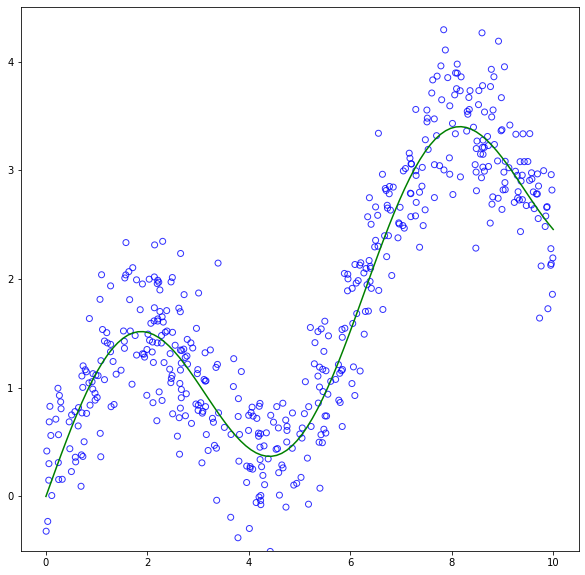

In [5]:
plt.figure(figsize=(10,10))
plt.plot(np.linspace(0,10,100), [Y(x) for x in np.linspace(0,10,100)] , color='green')
plt.xlim([-0.5, 10.5])
plt.ylim([-0.5, 4.5])
br = plt.scatter(x,y,  alpha=0.8, facecolors='none', edgecolors='blue')
plt.show

## LLR algorithm
#### Estimator:
+   $\hat f(x_0) = \hat\alpha(x_0)+\hat\beta(x_0)x_0$

+   $\hat\alpha$ and $\hat\beta$ are the linear regression coefficients estimated with sample values weighted around $x_0$

+   Solved by minimizing the weighted squared mean error:\
$\underset{\alpha(x_0),\beta(x_0)}\min\bigg\lgroup\underset{i=1}{\overset{N}\sum} K_k(x_0,x_i)[y_i-\alpha(x_0)-\beta(x_o)x_i]^2\bigg\rgroup$\
    +   $K_k(x_0,x_i)=D\Big(\frac{|x-x_0|}{h_k(x_0)}\Big)$ is the kernel function
    +   $h_k(x_0) = |x_0-x_k|$ return the distance to the border of the kernel
    +   $D(t)=\begin{cases}\frac{3}{4}(1-t^2) & |t|\leq 1\\ 0 & \text{otherwise}\\\end{cases}$
    +   In simple words the $k$ closest samples in the sample set are weighted by distance to the the prediction point $x0$ (the closer the larger the weight) and than are used in a linear regression. This regression is then evaluated at point x0.

+   We use the textbook solution with form:\
$\hat f(x_0) = b(x_0)^T(B^TW(x_0)B)^{-1}B^TW(x_0)y$
    +   $b(x)^T=(1,x)$
    +   $B$ is a $N \times 2$ with $b(x_i)^T$ in row $i$
    +   $W(x_0)$ is the $N \times N$ with the weights $K_k(x_0,x_i)$ along the diagonal


In [6]:
def fhatx0(X, Y, x0, k):
    assert k <= len(X)
    assert len(X) == len(Y)
    ################################
    # gen weight matrix    
    ################################
    # X -> (sum Y, count)
    x_sum_dic = {}
    for idx in range(0,len(X)):
        if X[idx] not in x_sum_dic:
            x_sum_dic[X[idx]] = (Y[idx], 1)
        else:
            (sum_y, count) = x_sum_dic.get(X[idx])
            x_sum_dic[X[idx]] = (sum_y + Y[idx], count + 1)
    XY = [(x, sum_y/count, count,) for x, (sum_y, count) in x_sum_dic.items()]
    # calc distance to point
    XY = [(x, y, c, abs(x-x0)) for x, y, c in XY]
    # sort by distance
    sorted_XY = [ xy for xy in sorted(XY, key= lambda x: x[3])]
    # with value x, average of y, how many y's got averaged, distance to x0, weight 
    # weight = how many y's got averaged (multiplied by the proportion of the distance group if at boarder and more new neighbours to add than space in the neighbourhood)
    neighbour_counter = 0
    neighbourhood = []
    max_neighbour_distance = 0
    while True:
        # get the first in line and all subsequent with same distance
        next_neighbours = [(sorted_XY.pop(0) + (1,))]
        neighbour_counter += next_neighbours[0][2] # note if this is a averaged x from more than 1 value we count increase the count respectivly
        while len(sorted_XY) > 0 and  sorted_XY[0][3] == next_neighbours[0][3]:
            new_neighbour = (sorted_XY.pop(0) +(1,))
            next_neighbours.append(new_neighbour)
            neighbour_counter += new_neighbour[2]
        # if there is still space for neighbours ergo we are not at the border we dont care if there are x's with equal distance because all go completely into neighbourhood
        if neighbour_counter < k:
            neighbourhood.extend(next_neighbours)
        # elif we hit the boarder and fit perfectly we only add the new neighbours and break out of the while loop
        elif neighbour_counter == k:
            neighbourhood.extend(next_neighbours)
            max_neighbour_distance = next_neighbours[0][3]
            break
        # in the last case we hit the boarder but there are more neighbours than space in the neighbourhood -> we 
        else:
            # stuff only relevant if the border group has influence -> our kernel does not
            border_group_size = sum([c for x, y, c, d, w in next_neighbours])
            free_space_in_neighbourhood = k - (neighbour_counter - border_group_size)
            assert free_space_in_neighbourhood < border_group_size
            weighting_coefficient = free_space_in_neighbourhood / border_group_size
            # weight for each group is their proportion in the border group adjusted for the free space
            next_neighbours = [ (x, y, c, d, c*weighting_coefficient) for  x, y, c, d, w in next_neighbours]
            neighbourhood.extend(next_neighbours)
            max_neighbour_distance = next_neighbours[0][3]
            break
    # calc t for each element using the max distance of the kth neighbour (max_neighbour_distance)
    neighbourhood = [(x,y,c,d, abs(x-x0)/max_neighbour_distance)  for x, y, c, d, w in neighbourhood]
    # calc D(t)
    # note if D(t)==0 then automticly discard it cause it has no influence on regression
    neighbourhood = [(x,y,c,d, 3/4*(1-(t**2)))  for x, y, c, d, t in neighbourhood if abs(t) < 1]  # else (x,y,c,d,0) 
    # adjust kernel weights with the count 
    neighbourhood = [(x,y,c,d, w*c)  for x, y, c, d, w in neighbourhood]
    # create W(x0)
    Wx0 = [w for x,y,c,d,w in neighbourhood] * np.identity(len(neighbourhood))
    ################################
    # create Matricies and eval for x0
    ################################
    bx0 = np.array((1, x0))
    B = np.array((np.ones(len(neighbourhood)), [x for x,y,c,d,w in neighbourhood])).T
    y = np.array( [y for x,y,c,d,w in neighbourhood])
    # calc the model prediction at x0
    fhatx0 = bx0 @ np.linalg.inv(B.T @ Wx0 @ B) @ B.T @ Wx0 @ y
    #print(f"fhatx0 = {fhatx0}")
    return fhatx0

### Plot $\hat f(x)$

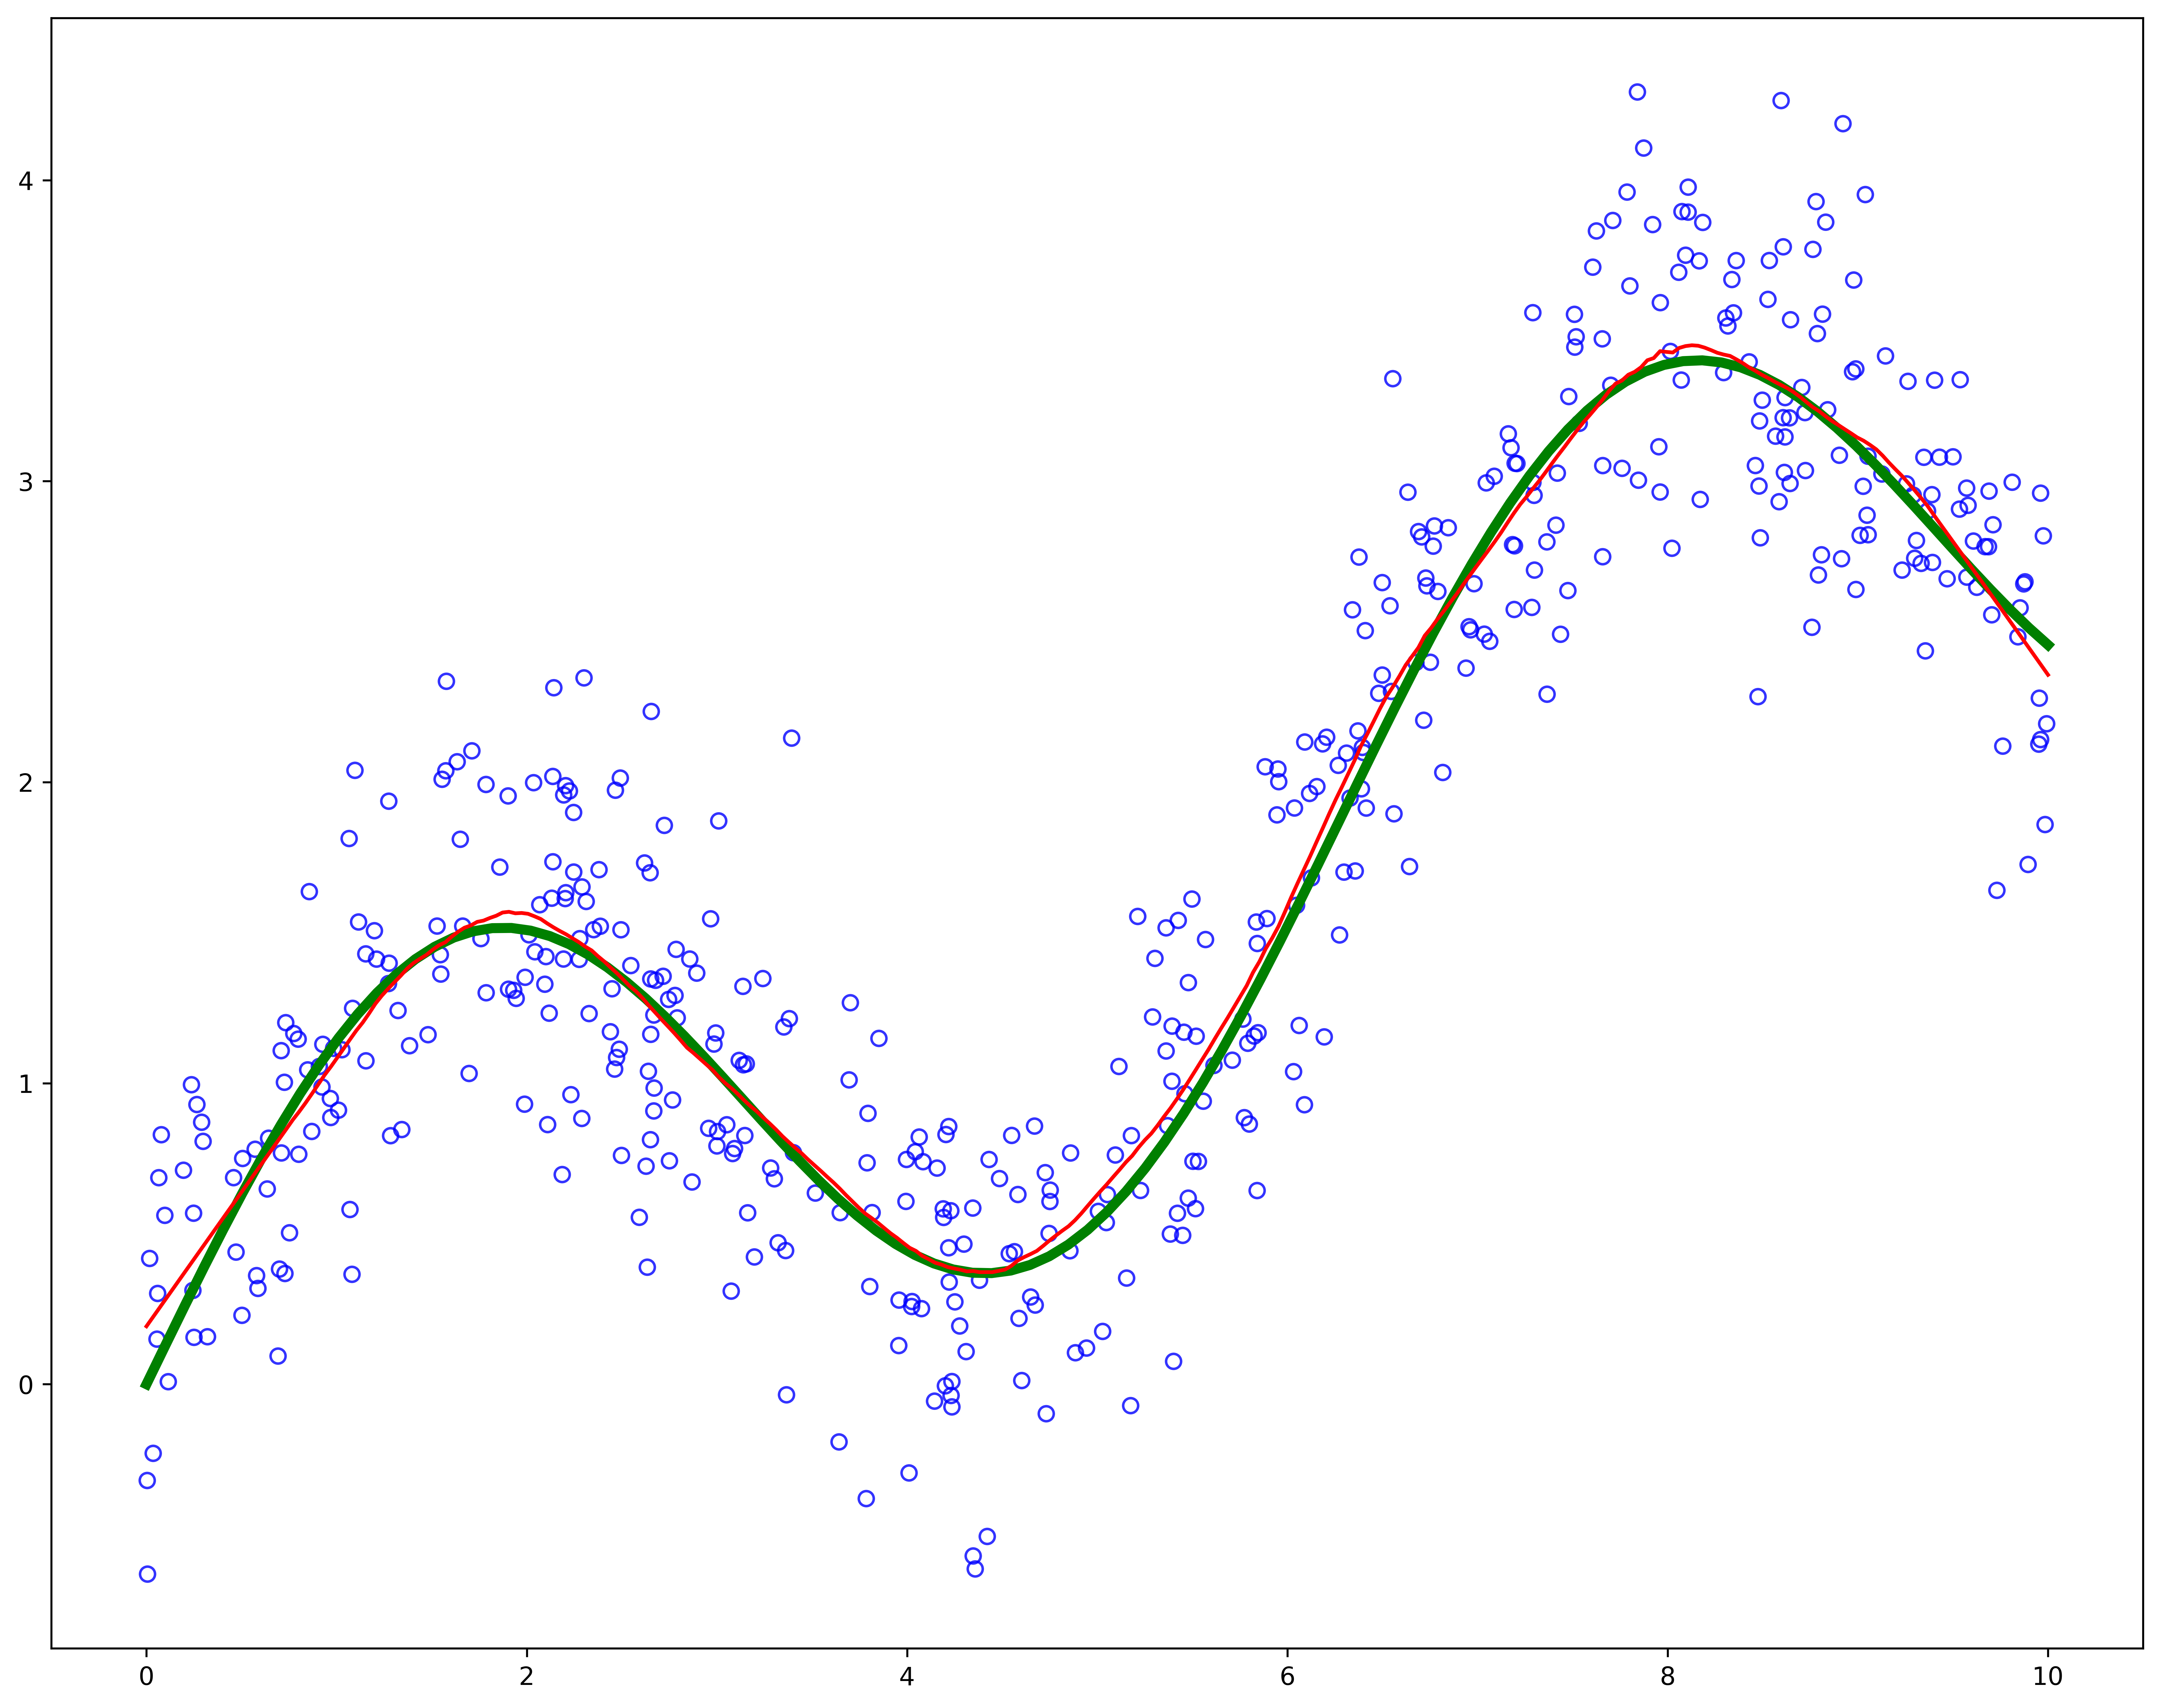

In [7]:
plt.figure( figsize=(15,12), dpi=600)
plt.plot(np.linspace(0,10,100), [Y(x) for x in np.linspace(0,10,100)] , color='green', linewidth=4)
plt.scatter(x,y, alpha=0.8, facecolors='none', edgecolors='blue')
plt.plot(np.linspace(0,10,300), [fhatx0(x, y, x0, k) for x0 in np.linspace(0,10,300)] , color='red')
plt.show()

### References
*   Hastie, Trevor ; Tibshirani, Robert ; Friedman, Jerome: The Elements of Statistical Learning : Data Mining, Inference, and Prediction. Berlin-Heidelberg: Springer New York, 2017.